# 1.&nbsp; Import Libraries

First things first is import the necessary libraries

In [ ]:
!pip install split-folders
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import glob
from io import BytesIO
import os
import re
import PIL
from PIL import Image
import shutil
import pathlib
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Input, Conv2D, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
import gc
from google.colab import files
from rembg import remove
import time
import io

import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(tf.__version__)

print(tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU')
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


#2.&nbsp;Load Dataset

Then mount the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src = '/content/drive/MyDrive/Skripsi/Dataset/original_dataset'
dst = '/content/original_dataset'

shutil.copytree(src, dst)
print("Successfully copied to local Colab")

Successfully copied to local Colab


#3.&nbsp;Data Exploration

Just like formality that use to explore the data

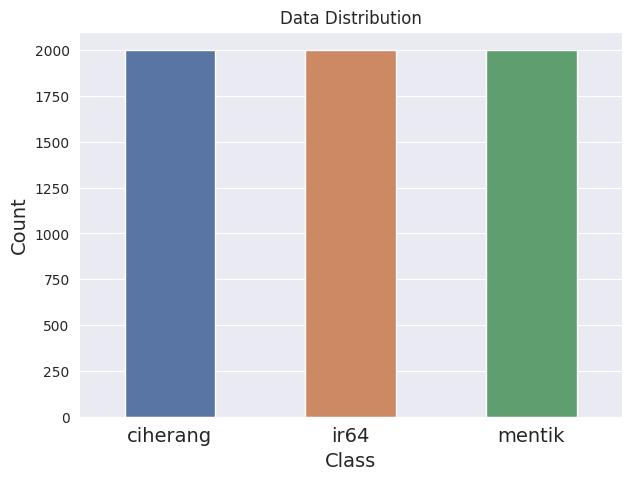

In [ ]:
data = '/content/original_dataset'

ciherang = glob.glob(os.path.join(data, 'ciherang', '*.jpg'))
ir64 = glob.glob(os.path.join(data, 'ir64', '*.jpg'))
mentik = glob.glob(os.path.join(data, 'mentik', '*.jpg'))

rice = [ciherang, ir64, mentik]
rice_classes = ['ciherang', 'ir64', 'mentik']
rice_count = [len(rice_class) for rice_class in rice]

sns.set_style('darkgrid')
plt.figure(figsize=(7, 5))
sns.barplot(x=rice_classes, y=rice_count, palette='deep', width=0.5, )
plt.xlabel('Class', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize=14)
plt.title('Data Distribution')
plt.show()

In [ ]:
rice_classes = ['ciherang', 'ir64', 'mentik']
def load_random_img(base_dir, labels, seed=42):
    if seed is not None:
        random.seed(seed)

    plt.figure(figsize=(10, 5))
    for i, label in enumerate(labels):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                image_path = os.path.join(class_dir, random.choice(image_files))
                sample_img = cv2.imread(image_path)
                if sample_img is not None:
                    plt.subplot(1, len(labels), i + 1)
                    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
                    plt.title(label)
                    plt.axis('off')
    plt.show()

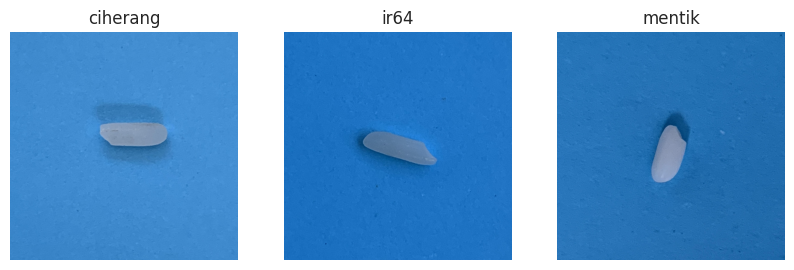

In [ ]:
load_random_img(data, rice_classes)

#4.&nbsp;Data Preprocessing

As we can see, that each images of dataset contain blue-texture background and too broad. So we have to overcome it with the following:


1.   Remove the unecessary background
2.   Convert to grayscale format
3.   Then, crop the image
4.   And revert to RGB format



##4.1&nbsp;Background Removal

To remove the background we employ the rembg library that use the pre-trained model U^2-Net as backbone so the background removing process can be easier and smoother.

In [ ]:
def remove_bg(class_name):
    input_dir = f'/content/original_dataset/{class_name}'
    output_dir = f'/content/drive/MyDrive/Skripsi/Dataset/background_removed/{class_name}'
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]
    print(f"Removing background for class: {class_name} ({len(files)} images)")

    start_time = time.time()
    for filename in files:
        name_wo_ext = os.path.splitext(filename)[0]
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f'no_bg_{name_wo_ext}.png')

        try:
            with open(input_path, 'rb') as inp:
                input_img = inp.read()
                output_img = remove(input_img)

            img = Image.open(io.BytesIO(output_img)).convert("RGBA")
            img.save(output_path, format="PNG")
        except:
            pass

    end_time = time.time()
    duration = end_time - start_time
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Finished processing the {class_name} class. Duration: {minutes} minutes {seconds} seconds\n")

In [ ]:
remove_bg('ciherang')

Removing background for class: ciherang (2000 images)


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 154GB/s]


Finished processing the ciherang class. Duration: 108 minutes 52 seconds



In [ ]:
remove_bg('ir64')

Removing background for class: ir64 (2000 images)
Finished processing the ir64 class. Duration: 106 minutes 8 seconds



In [ ]:
remove_bg('mentik')

Removing background for class: mentik (2000 images)
Finished processing the mentik class. Duration: 106 minutes 15 seconds



After that, we need to visualize the sample after background removing, just make sure that the background removal is work well

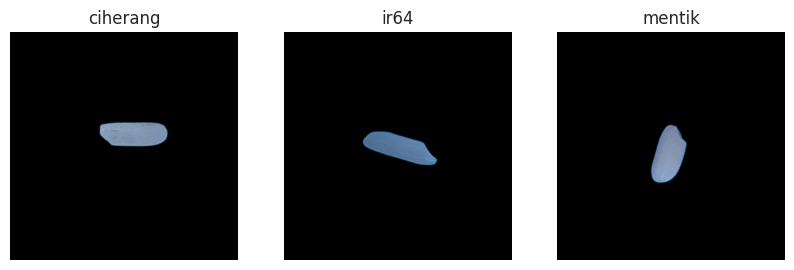

In [ ]:
rembg = "/content/drive/MyDrive/Skripsi/Dataset/background_removed"
load_random_img(rembg, rice_classes)

##4.2&nbsp;Grayscale Conversion

As we can see above, that the color of objcet (rice grain) is effected by the background, due to this we should convert to grayscale format

In [ ]:
def convert2grayscale(class_name):
    input_dir = f'/content/drive/MyDrive/Skripsi/Dataset/background_removed/{class_name}'
    output_dir = f'/content/drive/MyDrive/Skripsi/Dataset/grayscale_no_bg/{class_name}'
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir) if f.lower().endswith('.png')]
    print(f"Converting to grayscale: {class_name} ({len(files)} images)")

    start_time = time.time()
    for filename in files:
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            img = Image.open(input_path).convert("L")
            img.save(output_path)
        except:
            pass

    end_time = time.time()
    duration = end_time - start_time
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Finished processing the {class_name} class. Duration: {minutes} minutes {seconds} seconds\n")

In [ ]:
convert2grayscale('ciherang')

Converting to grayscale: ciherang (2000 images)
Finished processing the ciherang class. Duration: 8 minutes 31 seconds



In [ ]:
convert2grayscale('ir64')

Converting to grayscale: ir64 (2000 images)
Finished processing the ir64 class. Duration: 8 minutes 32 seconds



In [ ]:
convert2grayscale('mentik')

Converting to grayscale: mentik (2000 images)
Finished processing the mentik class. Duration: 8 minutes 25 seconds



In [ ]:
def check_grayscale(image_path):
    image = Image.open(image_path)
    if image.mode in ("L", "LA"):
        return "The image is grayscale."
    else:
        return "The image is not grayscale."

img = "/content/drive/MyDrive/Skripsi/Dataset/grayscale_no_bg/ciherang/no_bg_IMG_0001.png"
check_grayscale(img)

'The image is grayscale.'

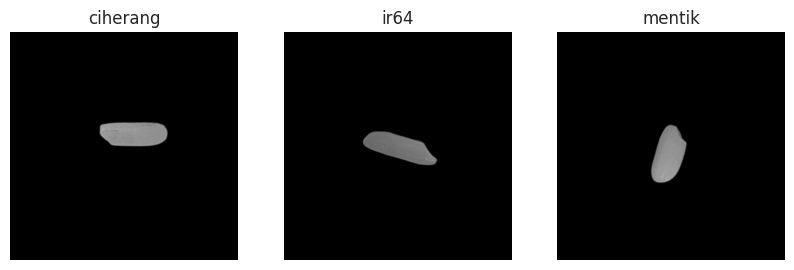

In [ ]:
gryscl = "/content/drive/MyDrive/Skripsi/Dataset/grayscale_no_bg"
load_random_img(gryscl, rice_classes)

##4.3 Image Cropping

After several preprocessing, we still can see that the image have too broad background, this may interfere with the feature extraction process.

In [ ]:
def crop_image(class_name):
    input_dir = f'/content/drive/MyDrive/Skripsi/Dataset/grayscale_no_bg/{class_name}'
    output_dir = f'/content/drive/MyDrive/Skripsi/Dataset/cropped/{class_name}'
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir) if f.lower().endswith('.png')]
    print(f"Cropping images: {class_name} ({len(files)} images)")

    start_time = time.time()
    for filename in files:
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        if os.path.exists(output_path):
            continue

        try:
            image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            _, mask = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                side = int(max(w, h) * 1.5)
                cx, cy = x + w // 2, y + h // 2
                x1, y1 = max(0, cx - side // 2), max(0, cy - side // 2)
                side = min(side, min(image.shape[1] - x1, image.shape[0] - y1))
                cropped = image[y1:y1 + side, x1:x1 + side]
                cv2.imwrite(output_path, cropped)
        except:
            pass

    end_time = time.time()
    duration = end_time - start_time
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Finished processing the {class_name} class. Duration: {minutes} minutes {seconds} seconds\n")

In [ ]:
crop_image('ciherang')

Cropping images: ciherang (2000 images)
Finished processing the ciherang class. Duration: 2 minutes 49 seconds



In [ ]:
crop_image('ir64')

Cropping images: ir64 (2000 images)
Finished processing the ir64 class. Duration: 2 minutes 42 seconds



In [ ]:
crop_image('mentik')

Cropping images: mentik (2000 images)
Finished processing the mentik class. Duration: 2 minutes 35 seconds



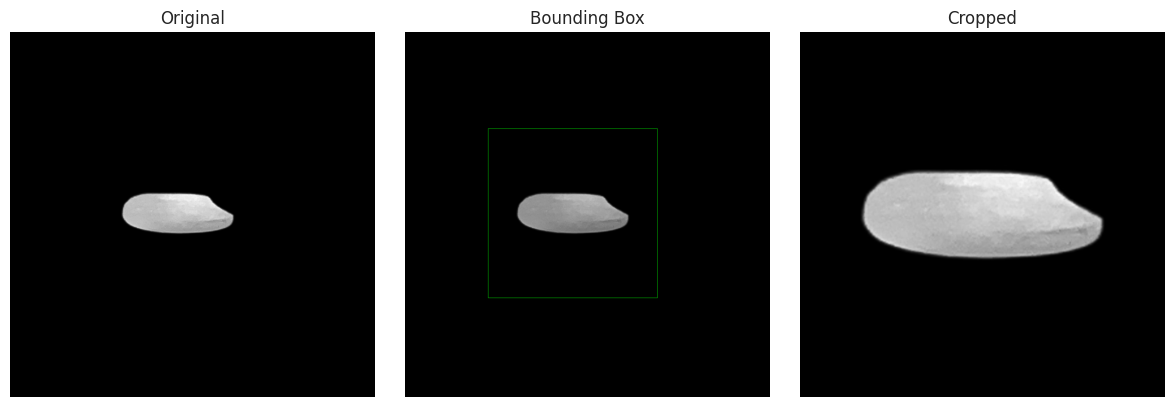

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Skripsi/Dataset/New/grayscale_no_bg/ciherang/no_bg_IMG_0001.png', cv2.IMREAD_GRAYSCALE)
_, mask = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
side = int(max(w, h) * 1.5)
cx, cy = x + w // 2, y + h // 2
x1, y1 = max(0, cx - side // 2), max(0, cy - side // 2)
cropped = img[y1:y1 + side, x1:x1 + side]

boxed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.rectangle(boxed, (x1, y1), (x1 + side, y1 + side), (0, 255, 0), 2)

plt.figure(figsize=(12, 4))
for i, (title, im) in enumerate(zip(['Original', 'Bounding Box', 'Cropped'], [img, boxed, cropped])):
    plt.subplot(1, 3, i + 1)
    plt.imshow(im, cmap='gray' if i != 1 else None)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

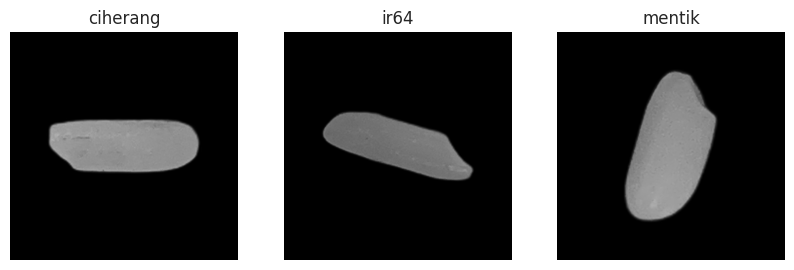

In [ ]:
cropped = "/content/drive/MyDrive/Skripsi/Dataset/cropped"
load_random_img(cropped, rice_classes)

##4.4 RGB Conversion

All the main preprocessing has been done, it's time to revert the format to RGB by using cv2.COLOR_GRAY2RGB, this is final step but not serious final :v

In [ ]:
def convert2rgb(class_name):
    input_dir = f'/content/drive/MyDrive/Skripsi/Dataset/cropped/{class_name}'
    output_dir = f'/content/drive/MyDrive/Skripsi/Dataset/clean_dataset/{class_name}'
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir) if f.lower().endswith('.png')]
    print(f"Converting to RGB: {class_name} ({len(files)} images)")

    start_time = time.time()
    for filename in files:
        input_path = os.path.join(input_dir, filename)
        num_img = ''.join(filter(str.isdigit, os.path.splitext(filename)[0]))
        if not num_img:
            continue

        output_path = os.path.join(output_dir, f'clean_IMG_{num_img}.png')
        if os.path.exists(output_path):
            continue

        try:
            gray_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if gray_img is None:
                continue
            rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
            cv2.imwrite(output_path, rgb_img)
        except:
            continue

    end_time = time.time()
    duration = end_time - start_time
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Finished processing the {class_name} class. Duration: {minutes} minutes {seconds} seconds\n")

In [ ]:
convert2rgb('ciherang')

Converting to RGB: ciherang (4000 images)
Finished processing the ciherang class. Duration: 0 minutes 2 seconds



In [ ]:
convert2rgb('ir64')

Converting to RGB: ir64 (4000 images)
Finished processing the ir64 class. Duration: 0 minutes 1 seconds



In [ ]:
convert2rgb('mentik')

Converting to RGB: mentik (4000 images)
Finished processing the mentik class. Duration: 0 minutes 2 seconds



In [ ]:
check_grayscale("/content/drive/MyDrive/Skripsi/Dataset/clean_datasetV2/ciherang/clean_IMG_0001.png")

/content/drive/MyDrive/Skripsi/Dataset/clean_datasetV2/ciherang/clean_IMG_0001.png: The image has 3 channels.


#5&nbsp;Dataset Splitting & Loading

Split dataset into 3 subset (train, val, test)

In [ ]:
data = '/content/drive/MyDrive/Skripsi/Dataset/clean_dataset'
output_dir = '/content/drive/MyDrive/Skripsi/Dataset/New/split_dataset'

splitfolders.ratio(data, output=output_dir, seed=42, ratio=(.8, .1, .1))

Copying files: 6000 files [02:09, 46.49 files/s]


Then copy to local colab directory for smoother computation

In [ ]:
src = '/content/drive/MyDrive/Skripsi/Dataset/split_dataset'
dst = '/content/dataset'

shutil.copytree(src, dst)
print("Successfully copied to local Colab")

Successfully copied to local Colab


Declare dataset loading code

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = datagen.flow_from_directory(
    '/content/dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    '/content/dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


Just make sure that the split is working properly

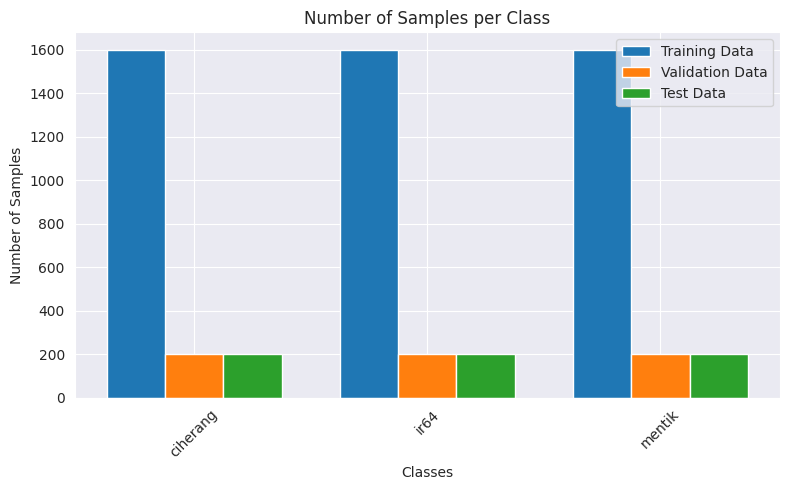

In [ ]:
train_classes = train_data.classes
val_classes = val_data.classes
test_classes = test_data.classes

class_labels = list(train_data.class_indices.keys())

train_class_count = np.bincount(train_classes)
val_class_count = np.bincount(val_classes)
test_class_count = np.bincount(test_classes)

total_class_count = train_class_count + val_class_count + test_class_count
x = np.arange(len(class_labels))
width = 0.25

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, train_class_count, width, label='Training Data')
ax.bar(x, val_class_count, width, label='Validation Data')
ax.bar(x + width, test_class_count, width, label='Test Data')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#6.&nbsp;Modeling

##6.1 Transfer Learning

**Densenet-201 with Transfer Learning** <br>
> Create model by loading the pre-trained DenseNet-201, employ the Imagenet weights then freeze all layers and modify the head (classifier).

In [ ]:
def build_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,292,163 (77.41 MB)

 Trainable params: 1,970,179 (7.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

##6.2 Non-Transfer Learning
**Densenet-201 Non-Transfer Learning/Training from scratch** <br>
> Create model by initializing DenseNet-201 with random weights and training all layers from the beginning.

In [ ]:
def build_model_nonTL(input_shape=(224, 224, 3), num_classes=3):
    base_model = DenseNet201(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model_nonTL()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,292,163 (77.41 MB)

 Trainable params: 20,063,107 (76.53 MB)

 Non-trainable params: 229,056 (894.75 KB)

#7.&nbsp;Model Training

Create train_model to make it easier to train the model with several scenarios

In [ ]:
def train_model(model, train_data, val_data, epochs=10, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    start = time.time()
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data
    )
    end = time.time()
    duration = end - start
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Training completed in {minutes}m {seconds}s")
    return history, duration

create plot_history to visualize the model history

In [ ]:
def plot_history(history):
    if not history or not hasattr(history, 'history'):
        print("History is empty.")
        return

    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def save_history(history, filename):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(filename, index=False)
    print(f"History is saved to: {filename}")

##7.1 Transfer Learning

Voila, it's time to training the model

####a. Epoch 10

In [ ]:
model_10 = build_model()
history_10, duration_10 = train_model(model_10, train_data, val_data, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 188s 986ms/step - accuracy: 0.7156 - loss: 0.7930 - val_accuracy: 0.8650 - val_loss: 0.3224
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 776ms/step - accuracy: 0.8747 - loss: 0.2995 - val_accuracy: 0.8817 - val_loss: 0.3090
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 791ms/step - accuracy: 0.8901 - loss: 0.2587 - val_accuracy: 0.8883 - val_loss: 0.2807
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 784ms/step - accuracy: 0.8990 - loss: 0.2261 - val_accuracy: 0.8950 - val_loss: 0.2610
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 845ms/step - accuracy: 0.9124 - loss: 0.2060 - val_accuracy: 0.9117 - val_loss: 0.2346
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 784ms/step - accuracy: 0.9200 - loss: 0.1966 - val_accuracy: 0.9100 - val_loss: 0.2460
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 798ms/step - accuracy: 0.9325 - loss: 0.1705 - val_accuracy: 0.8967 - val_loss: 0.2505
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 804ms/step - accuracy: 0.9368 -

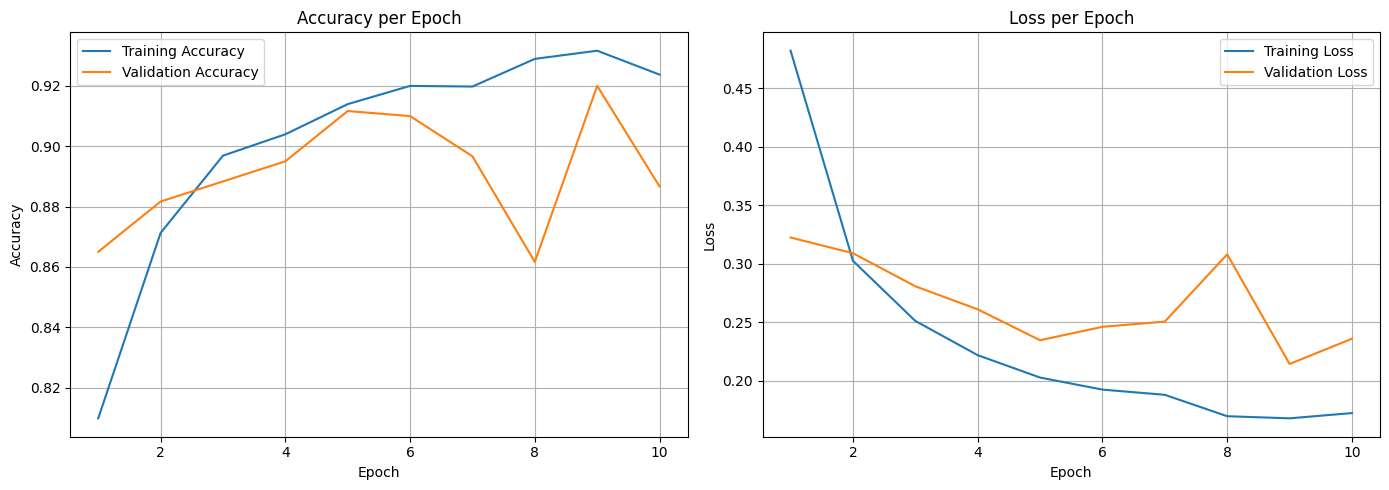

In [ ]:
plot_history(history_10)

In [ ]:
save_history(history_10, "/content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_10epoch.csv")
model_10.save("/content/drive/MyDrive/Skripsi/Logs/New/TL_model_10epoch.keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_10epoch.csv


####b. Epoch 20

In [ ]:
model_20 = build_model()
history_20, duration_20 = train_model(model_20, train_data, val_data, epochs=20)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7413 - loss: 0.6971 - val_accuracy: 0.8883 - val_loss: 0.3005
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 797ms/step - accuracy: 0.8817 - loss: 0.2730 - val_accuracy: 0.8967 - val_loss: 0.2727
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 846ms/step - accuracy: 0.8860 - loss: 0.2568 - val_accuracy: 0.8900 - val_loss: 0.2455
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 802ms/step - accuracy: 0.9120 - loss: 0.2081 - val_accuracy: 0.8350 - val_loss: 0.4384
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 786ms/step - accuracy: 0.8939 - loss: 0.2397 - val_accuracy: 0.8833 - val_loss: 0.2440
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 790ms/step - accuracy: 0.9192 - loss: 0.1954 - val_accuracy: 0.8900 - val_loss: 0.2664
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 782ms/step - accuracy: 0.9158 - loss: 0.1951 - val_accuracy: 0.9117 - val_loss: 0.2138
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 151s 845ms/step - accuracy: 0.9309 - lo

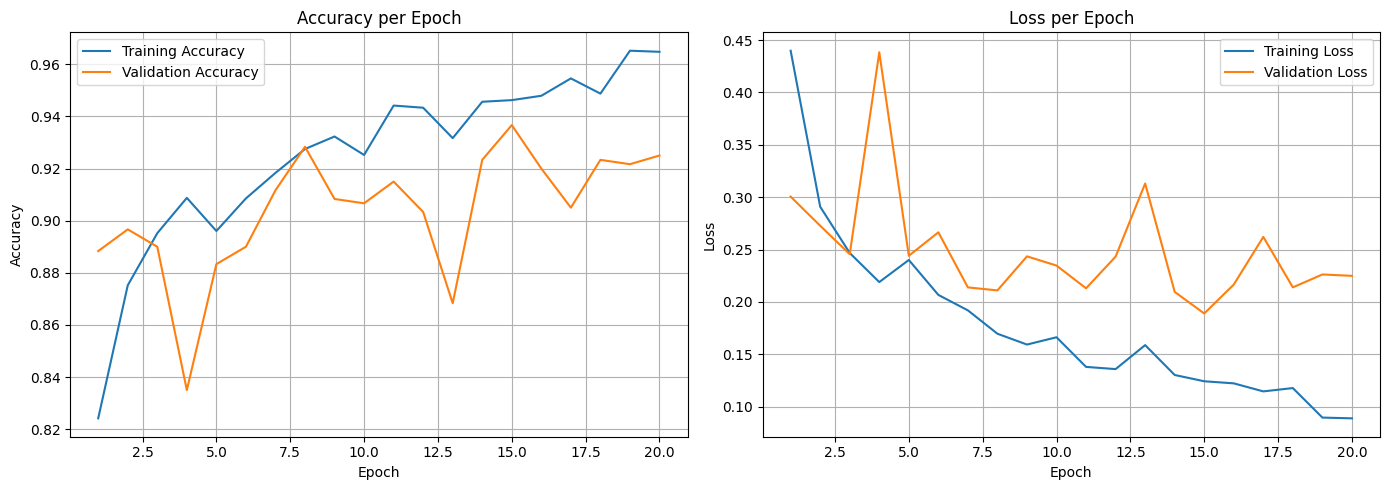

In [ ]:
plot_history(history_20)

In [ ]:
save_history(history_20, "/content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_20epoch.csv")
model_20.save("/content/drive/MyDrive/Skripsi/Logs/New/TL_model_20epoch.keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_20epoch.csv


####c. Epoch 30

In [ ]:
model_30 = build_model()
history_30, duration_30 = train_model(model_30, train_data, val_data, epochs=30)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 185s 988ms/step - accuracy: 0.6980 - loss: 0.8125 - val_accuracy: 0.8450 - val_loss: 0.3512
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 833ms/step - accuracy: 0.8693 - loss: 0.3027 - val_accuracy: 0.8767 - val_loss: 0.2725
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 827ms/step - accuracy: 0.8993 - loss: 0.2328 - val_accuracy: 0.8983 - val_loss: 0.2365
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 775ms/step - accuracy: 0.8985 - loss: 0.2331 - val_accuracy: 0.9033 - val_loss: 0.2224
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 816ms/step - accuracy: 0.9184 - loss: 0.1968 - val_accuracy: 0.9100 - val_loss: 0.2146
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 765ms/step - accuracy: 0.9000 - loss: 0.2255 - val_accuracy: 0.9050 - val_loss: 0.2171
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 761ms/step - accuracy: 0.9314 - loss: 0.1621 - val_accuracy: 0.9150 - val_loss: 0.2269
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 774ms/step - accuracy: 0.9230 -

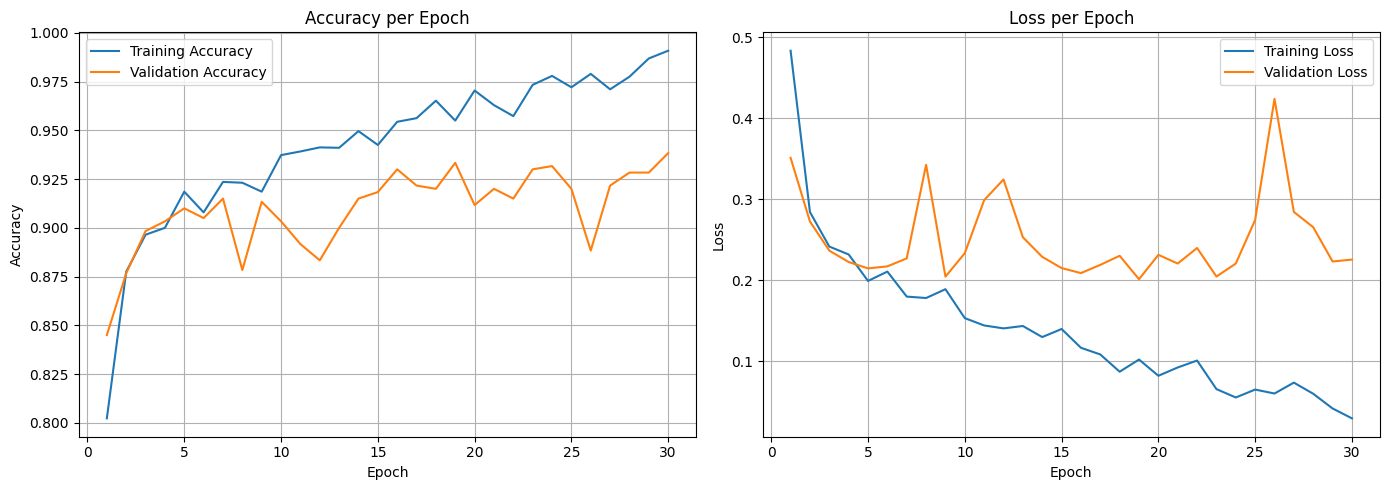

In [ ]:
plot_history(history_30)

In [ ]:
save_history(history_30, "/content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_30epoch(2).csv")
model_30.save("/content/drive/MyDrive/Skripsi/Logs/New/TL_model_30epoch(2).keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_TL_model_30epoch(2).csv


##7.2 Non-Transfer Learning

####a. Epoch 10

In [ ]:
model_10_nonTL = build_model_nonTL()
history_10_nonTL, duration_10_nonTL = train_model(model_10_nonTL, train_data, val_data, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.6342 - loss: 0.9357 - val_accuracy: 0.3333 - val_loss: 52.7236
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 136s 902ms/step - accuracy: 0.8198 - loss: 0.3956 - val_accuracy: 0.3333 - val_loss: 22.0508
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 856ms/step - accuracy: 0.8601 - loss: 0.3486 - val_accuracy: 0.5917 - val_loss: 1.6675
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 850ms/step - accuracy: 0.8595 - loss: 0.3348 - val_accuracy: 0.5750 - val_loss: 1.9123
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 851ms/step - accuracy: 0.8735 - loss: 0.3007 - val_accuracy: 0.6633 - val_loss: 0.9553
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 850ms/step - accuracy: 0.8797 - loss: 0.3052 - val_accuracy: 0.7350 - val_loss: 0.6122
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 849ms/step - accuracy: 0.8923 - loss: 0.2627 - val_accuracy: 0.4983 - val_loss: 2.8540
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 857ms/step - accuracy: 0.8991 - 

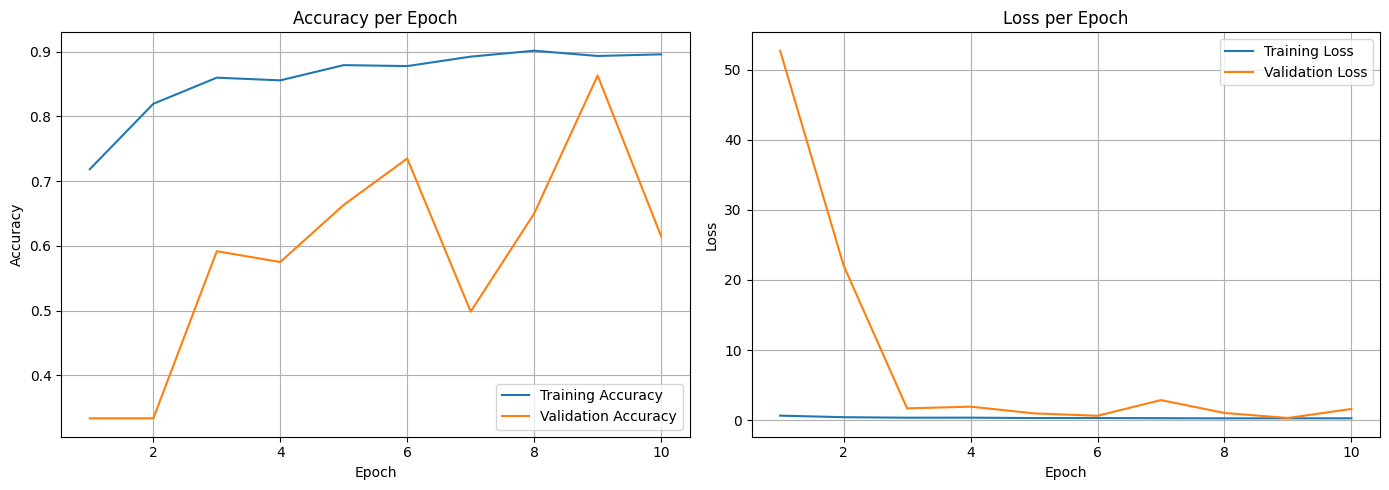

In [ ]:
plot_history(history_10_nonTL)

In [ ]:
save_history(history_10_nonTL, "/content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_10epoch(2).csv")
model_10_nonTL.save("/content/drive/MyDrive/Skripsi/Logs/New/nonTL_model_10epoch(2).keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_10epoch(2).csv


####b. Epoch 20

In [ ]:
model_20_nonTL = build_model_nonTL()
history_20_nonTL, duration_20_nonTL = train_model(model_20_nonTL, train_data, val_data, epochs=20)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.6646 - loss: 0.9112 - val_accuracy: 0.3600 - val_loss: 35.8205
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 946ms/step - accuracy: 0.8394 - loss: 0.3962 - val_accuracy: 0.3333 - val_loss: 57.0151
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 143s 951ms/step - accuracy: 0.8533 - loss: 0.3534 - val_accuracy: 0.3483 - val_loss: 14.6451
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 936ms/step - accuracy: 0.8661 - loss: 0.3070 - val_accuracy: 0.5900 - val_loss: 2.8691
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 939ms/step - accuracy: 0.8901 - loss: 0.2823 - val_accuracy: 0.3950 - val_loss: 17.7992
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 926ms/step - accuracy: 0.8676 - loss: 0.3167 - val_accuracy: 0.7233 - val_loss: 1.1910
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 935ms/step - accuracy: 0.8872 - loss: 0.2612 - val_accuracy: 0.3467 - val_loss: 5.3574
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 918ms/step - accuracy: 0.8890 

In [ ]:
save_history(history_20_nonTL, "/content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_20epoch.csv")
model_20_nonTL.save("/content/drive/MyDrive/Skripsi/Logs/New/nonTL_model_20epoch.keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_20epoch.csv


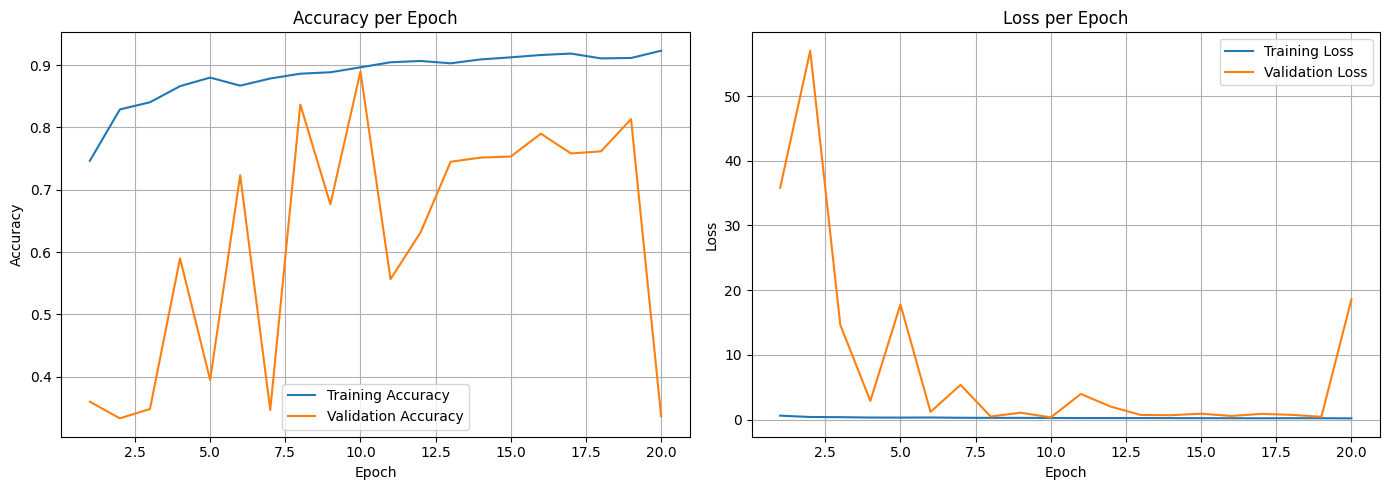

In [ ]:
plot_history(history_20_nonTL)

####c. Epoch 30

In [ ]:
model_30_nonTL = build_model_nonTL()
history_30_nonTL, duration_30_nonTL = train_model(model_30_nonTL, train_data, val_data, epochs=30)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.6619 - loss: 0.8948 - val_accuracy: 0.3333 - val_loss: 60.8910
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 175s 904ms/step - accuracy: 0.8217 - loss: 0.4097 - val_accuracy: 0.3333 - val_loss: 51.8189
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 929ms/step - accuracy: 0.8364 - loss: 0.3803 - val_accuracy: 0.3983 - val_loss: 2.5514
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 146s 969ms/step - accuracy: 0.8602 - loss: 0.3216 - val_accuracy: 0.8567 - val_loss: 0.3726
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 985ms/step - accuracy: 0.8672 - loss: 0.3085 - val_accuracy: 0.3333 - val_loss: 8.3788
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 926ms/step - accuracy: 0.8662 - loss: 0.3092 - val_accuracy: 0.8383 - val_loss: 0.4066
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 934ms/step - accuracy: 0.8981 - loss: 0.2730 - val_accuracy: 0.5833 - val_loss: 2.7875
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 137s 912ms/step - accuracy: 0.8873 - 

In [ ]:
save_history(history_30_nonTL, "/content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_30epoch.csv")
model_30_nonTL.save("/content/drive/MyDrive/Skripsi/Logs/New/nonTL_model_30epoch.keras")

History is saved to: /content/drive/MyDrive/Skripsi/Logs/New/history_nonTL_model_30epoch.csv


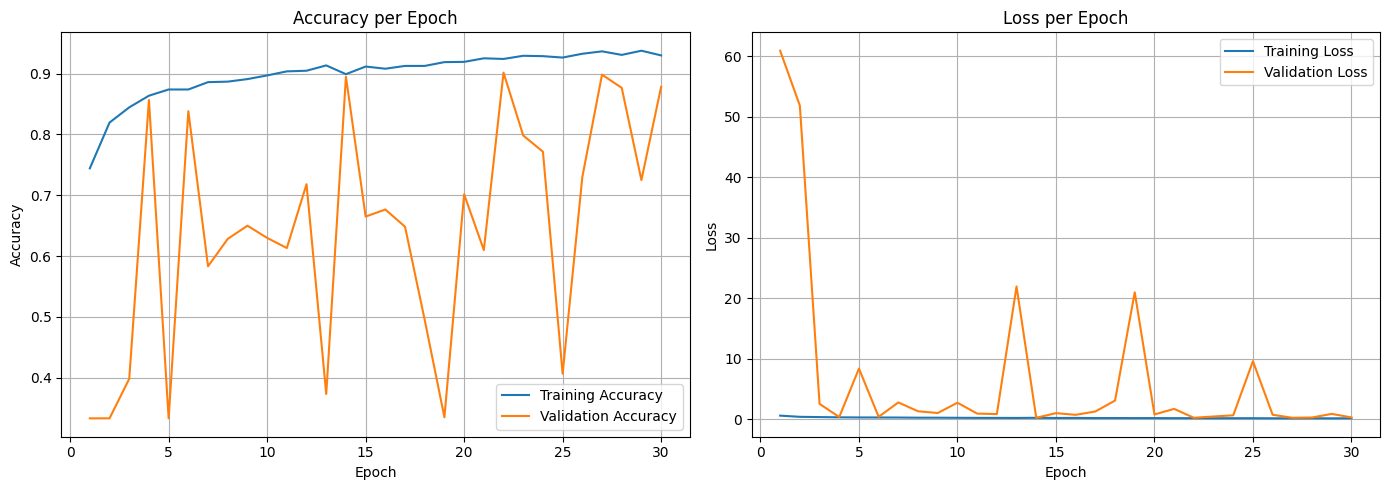

In [ ]:
plot_history(history_30_nonTL)

#8.&nbsp;Evaluation

As we can see based on training hostory above, that shown the best model in both method is at 30 epoch, so only 2 of them will be used to  go further as evaluating use confusion mtx and classiifier report

##8.1&nbsp;Confusion Matrix

In [ ]:
def plot_confusion_matrix(model, test_data = test_data):
    Y_pred = model.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)
    confusion_mtx = confusion_matrix(test_data.classes, y_pred)

    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        confusion_mtx,
        annot=True,
        linewidths=0.5,
        linecolor="white",
        fmt='d',
        cmap='Blues',
        ax=ax,
        annot_kws={"size": 12}
    )

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)

    class_names = list(test_data.class_indices.keys())
    ax.xaxis.set_ticklabels(class_names, fontsize=12, rotation=45)
    ax.yaxis.set_ticklabels(class_names, fontsize=12, rotation=0)
    plt.show()

###8.1.1 Transfer Learning

19/19 ━━━━━━━━━━━━━━━━━━━━ 266s 14s/step


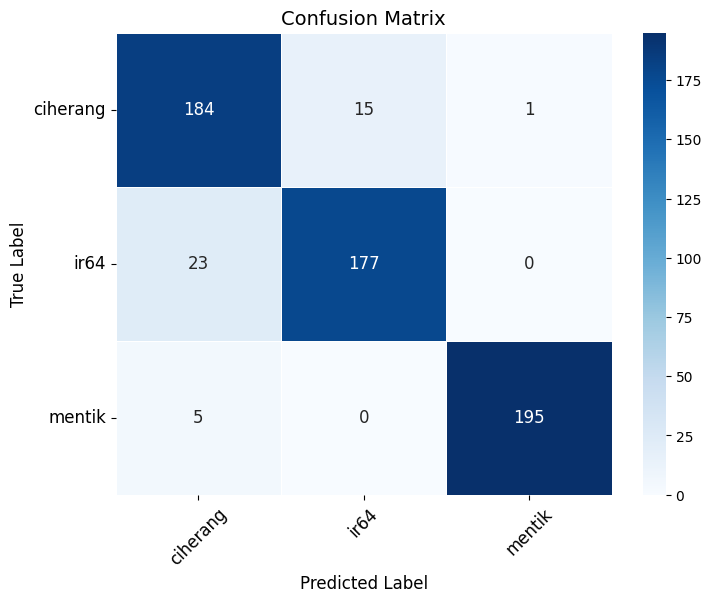

In [ ]:
model_30 = load_model('/content/drive/MyDrive/Skripsi/Logs/New/TL_model_30epoch(2).keras')
plot_confusion_matrix(model_30)

###8.1.1 Non-Transfer Learning

19/19 ━━━━━━━━━━━━━━━━━━━━ 303s 15s/step


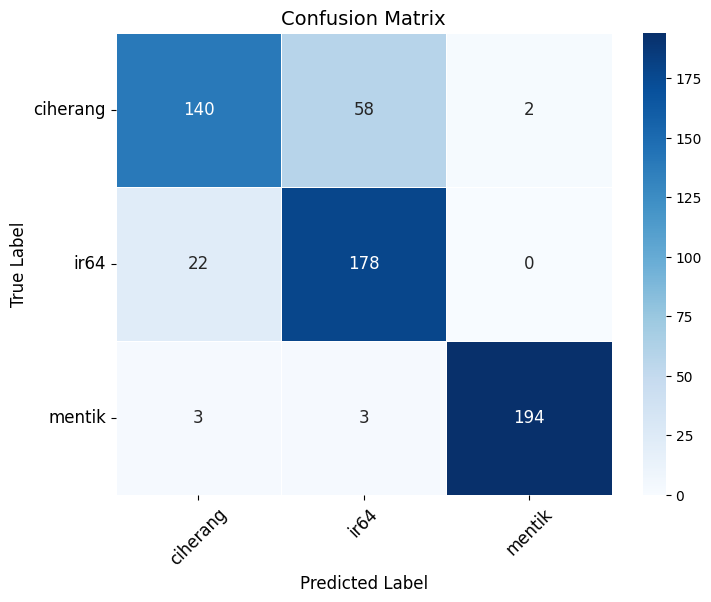

In [ ]:
model_30_nonTL = load_model('/content/drive/MyDrive/Skripsi/Logs/New/nonTL_model_30epoch.keras')
plot_confusion_matrix(model_30_nonTL)

##8.2&nbsp;Classification Report

In [ ]:
def evaluate_model(model, test_data = test_data):
    Y_pred = model.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_data.classes

    class_labels = list(test_data.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("\nClassification Report:")
    print(report)

###8.2.1 Transfer Learning

In [ ]:
evaluate_model(model_30)

19/19 ━━━━━━━━━━━━━━━━━━━━ 263s 14s/step

Classification Report:
              precision    recall  f1-score   support

    ciherang       0.87      0.92      0.89       200
        ir64       0.92      0.89      0.90       200
      mentik       0.99      0.97      0.98       200

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



###8.2.1 Non-Transfer Learning

In [ ]:
evaluate_model(model_30_nonTL)

19/19 ━━━━━━━━━━━━━━━━━━━━ 262s 14s/step

Classification Report:
              precision    recall  f1-score   support

    ciherang       0.85      0.70      0.77       200
        ir64       0.74      0.89      0.81       200
      mentik       0.99      0.97      0.98       200

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



#9.&nbsp;Result & Analysis

Analysis based on what we found

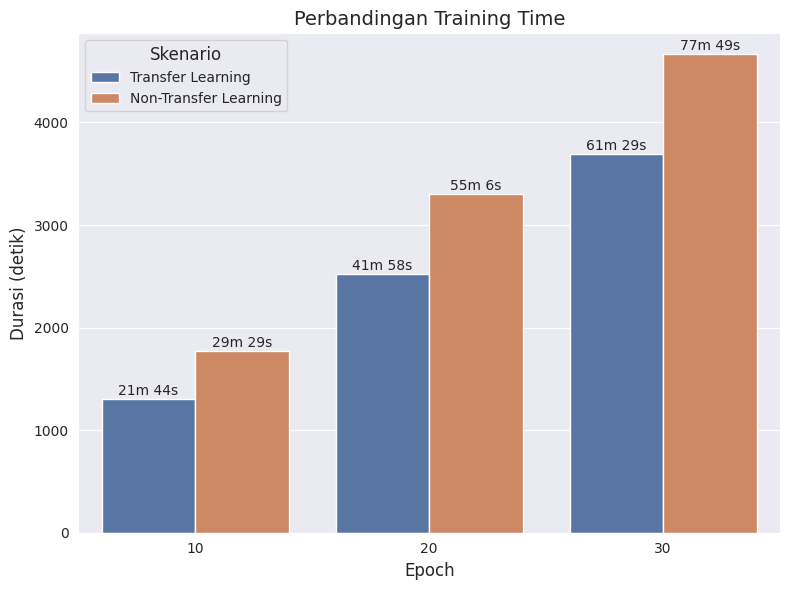

In [ ]:
data = {
    "Skenario": ["Transfer Learning", "Transfer Learning", "Transfer Learning", "Non-Transfer Learning", "Non-Transfer Learning", "Non-Transfer Learning"],
    "Epoch": [10, 20, 30, 10, 20, 30],
    "Durasi": [21 * 60 + 44, 41 * 60 + 58, 61 * 60 + 29, 29 * 60 + 29, 55 * 60 + 6, 77 * 60 + 49]
}
df = pd.DataFrame(data)

sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df, x="Epoch", y="Durasi", hue="Skenario", palette="deep")

plt.title("Perbandingan Training Time", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Durasi (detik)", fontsize=12)

max_duration = max(df["Durasi"])
plt.ylim(0, max_duration + 200)

def format_duration(seconds):
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes}m {seconds}s"

for container, scenario in zip(barplot.containers, df["Skenario"].unique()):
    scenario_data = df[df["Skenario"] == scenario]
    for bar, duration in zip(container, scenario_data["Durasi"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 10,
            format_duration(duration),
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.legend(title="Skenario", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

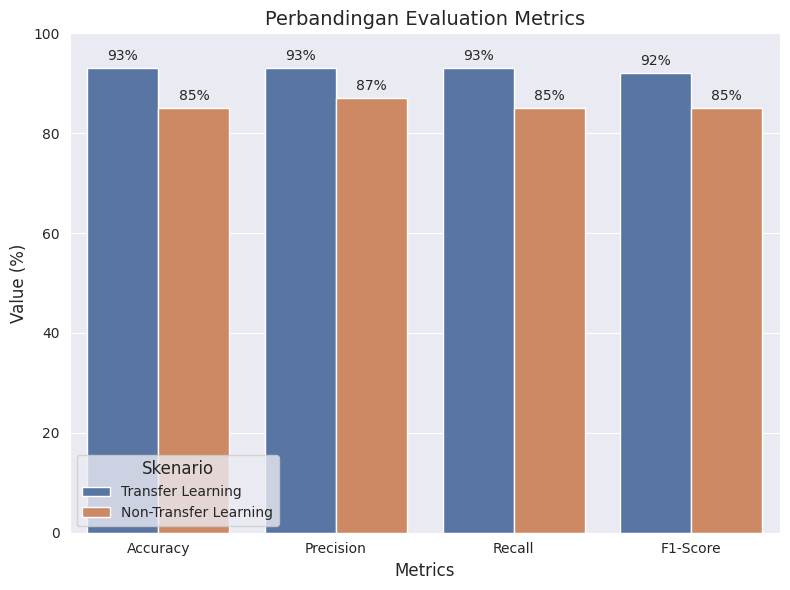

In [ ]:
data = {
    "Skenario": ["Transfer Learning", "Transfer Learning", "Transfer Learning", "Transfer Learning", "Non-Transfer Learning", "Non-Transfer Learning", "Non-Transfer Learning", "Non-Transfer Learning"],
    "Metrik": ["Accuracy", "Precision", "Recall", "F1-Score"] * 2,
    "Nilai": [93, 93, 93, 92, 85, 87, 85, 85]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="Metrik", y="Nilai", hue="Skenario", palette="deep")

plt.title("Perbandingan Evaluation Metrics", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Value (%)", fontsize=12)
plt.ylim(0, 100)

for container in ax.containers:
    for bar in container:
        bar_height = bar.get_height()
        if bar_height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height + 1,
                f"{bar_height:.0f}%",
                ha='center',
                va='bottom',
                fontsize=10
            )

plt.legend(title="Skenario", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

#10.&nbsp;Deployment Testing


Just check the model, whether the model can predict the test data or not

In [ ]:
model = load_model("/content/drive/MyDrive/Skripsi/Logs/New/TL_model_30epoch.keras")
rice_classes = ['ciherang', 'ir64', 'mentik']

def what_is(image_path):
    def color_text(text, color_code='33'):
        return f"\033[1;{color_code}m{text}\033[0m"

    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    predictions = model.predict(x)
    predicted_class = np.argmax(predictions, axis=1)[0]

    print(f'File: {image_path}')
    print(f'Identified class: {color_text(rice_classes[predicted_class], "33")}')

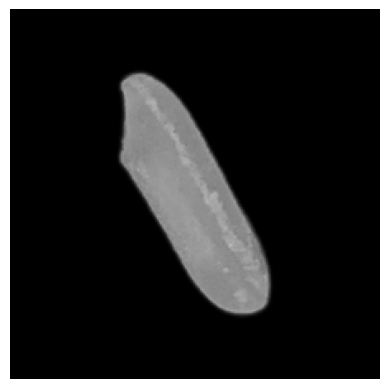

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
File: /content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/ciherang/clean_IMG_0014.png
Identified class: ciherang


In [ ]:
test1 = "/content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/ciherang/clean_IMG_0014.png"
what_is(test1)

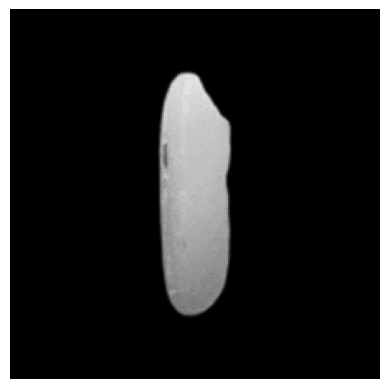

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
File: /content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/ir64/clean_IMG_0014.png
Identified class: ir64


In [ ]:
test2 = "/content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/ir64/clean_IMG_0014.png"
what_is(test2)

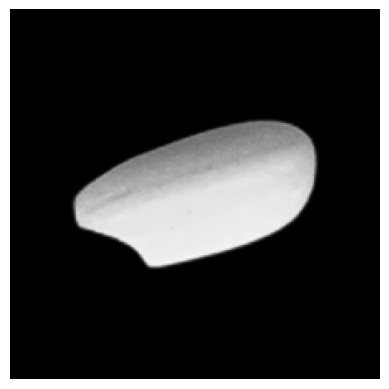

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
File: /content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/mentik/clean_IMG_0014.png
Identified class: mentik


In [ ]:
test3 = "/content/drive/MyDrive/Skripsi/Dataset/split_dataset/test/mentik/clean_IMG_0014.png"
what_is(test3)

#11.&nbsp;Rice grain pile test

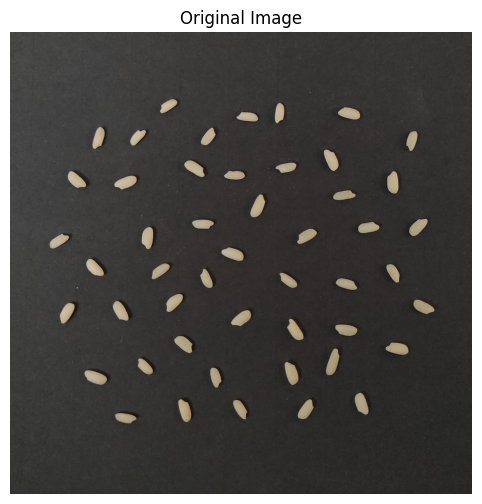

In [ ]:
biji = "/content/beras mentik.jpg"
beras  = Image.open(biji)
plt.figure(figsize=(10,6))
plt.title("Original Image")
plt.axis('off')
plt.imshow(beras)

##11.1 Connected Components

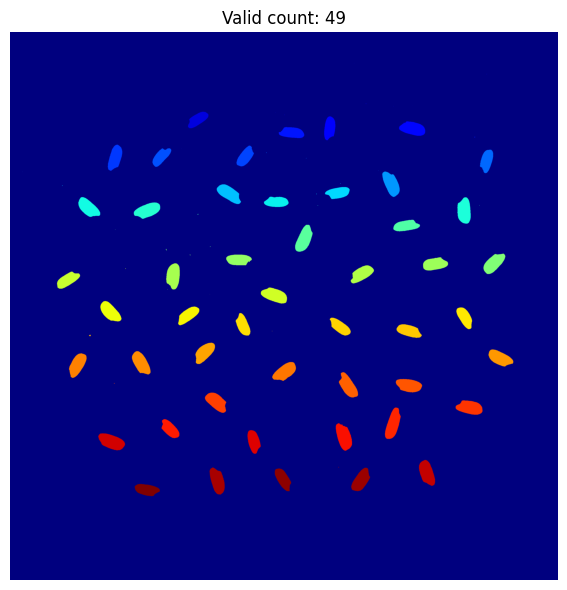

In [ ]:
ori_img = cv2.imread('beras mentik.jpg')
gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

output_folder = '/content/drive/MyDrive/Skripsi/Dataset/Mentik Susu Test'
os.makedirs(output_folder, exist_ok=True)

count = 0
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    if area < 60:
        continue

    side = int(max(w, h) * 1.5)
    cx_int, cy_int = int(cx), int(cy)
    x1, y1 = max(0, cx_int - side // 2), max(0, cy_int - side // 2)
    side = min(side, min(gray.shape[1] - x1, gray.shape[0] - y1))

    crop = gray[y1:y1 + side, x1:x1 + side]
    resized = cv2.resize(crop, (250, 250))
    rgb = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

    filename = f'mentik susu {count + 1}.png'
    cv2.imwrite(os.path.join(output_folder, filename), rgb)
    count += 1

plt.figure(figsize=(6, 6))
plt.imshow(labels, cmap='jet')
plt.title(f'Valid count: {count}')
plt.axis('off')
plt.tight_layout()
plt.show()

##11.2 Sanity Check

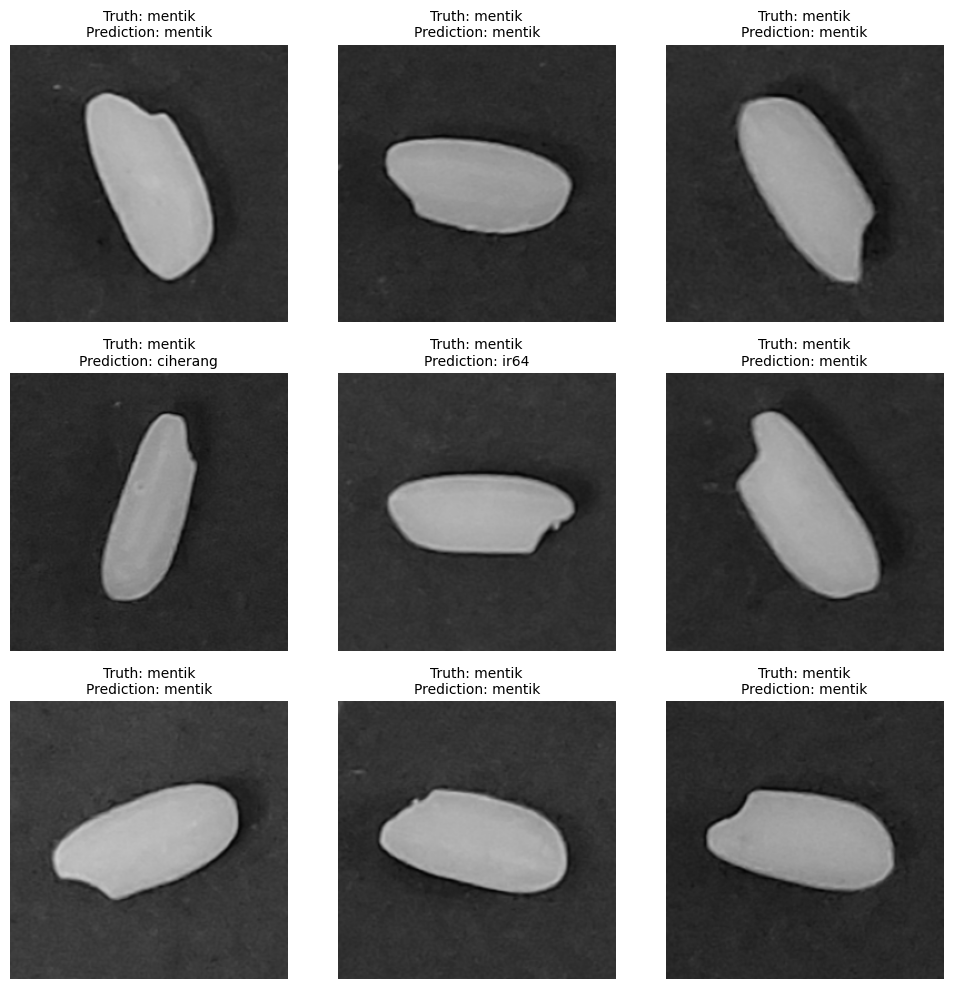

In [ ]:
test_dir = '/content/drive/MyDrive/Skripsi/Dataset/Mentik Susu Test'
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:9]

plt.figure(figsize=(10, 10))

for i, fname in enumerate(image_files):
    img_path = os.path.join(test_dir, fname)
    img_original = Image.open(img_path).convert("RGB")

    with open(img_path, 'rb') as f:
        input_bytes = f.read()
    output_bytes = remove(input_bytes)
    img_no_bg = Image.open(BytesIO(output_bytes)).convert("RGB")
    img_resized = img_no_bg.resize((224, 224))
    x = image.img_to_array(img_resized) / 255.0

    pred = model.predict(tf.expand_dims(x, 0), verbose=0)
    score = tf.nn.softmax(pred[0])
    pred_label = rice_classes[np.argmax(score)]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_original)
    plt.title(f"Truth: mentik\nPrediction: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

##11.3 Inference Result

In [ ]:
test_dir = '/content/drive/MyDrive/Skripsi/Dataset/Mentik Susu Test'
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

results = []
for fname in image_files:
    img_path = os.path.join(test_dir, fname)

    with open(img_path, 'rb') as f:
        input_bytes = f.read()
        output_bytes = remove(input_bytes)

    img_nobg = Image.open(BytesIO(output_bytes)).convert("RGB")
    img_resized = img_nobg.resize((224, 224))
    x = image.img_to_array(img_resized) / 255.0

    pred = model.predict(tf.expand_dims(x, 0), verbose=0)
    score = tf.nn.softmax(pred[0])
    pred_label = rice_classes[np.argmax(score)]

    results.append({
        'File Name': fname,
        'True Label': 'mentik',
        'Predicted Label': pred_label
    })

df_results = pd.DataFrame(results)
df_results

File Name True Label Predicted Label
0   mentik susu 50.png     mentik            ir64
1    mentik susu 9.png     mentik          mentik
2   mentik susu 37.png     mentik          mentik
3   mentik susu 48.png     mentik          mentik
4   mentik susu 40.png     mentik        ciherang
5   mentik susu 19.png     mentik            ir64
6   mentik susu 36.png     mentik          mentik
7   mentik susu 15.png     mentik          mentik
8    mentik susu 3.png     mentik          mentik
9   mentik susu 39.png     mentik          mentik
10  mentik susu 14.png     mentik          mentik
11  mentik susu 20.png     mentik          mentik
12  mentik susu 28.png     mentik          mentik
13  mentik susu 23.png     mentik          mentik
14   mentik susu 2.png     mentik          mentik
15  mentik susu 17.png     mentik          mentik
16  mentik susu 16.png     mentik            ir64
17  mentik susu 18.png     mentik          mentik
18  mentik susu 44.png     mentik          mentik
19  mentik susu 42.png     mentik          mentik
20  mentik susu 49.png     mentik            ir64
21   mentik susu 7.png     mentik          mentik
22  mentik susu 30.png     mentik          mentik
23  mentik susu 33.png     mentik          mentik
24  mentik susu 43.png     mentik          mentik
25  mentik susu 25.png     mentik          mentik
26  mentik susu 46.png     mentik          mentik
27  mentik susu 34.png     mentik          mentik
28  mentik susu 26.png     mentik          mentik
29  mentik susu 10.png     mentik          mentik
30  mentik susu 13.png     mentik          mentik
31  mentik susu 22.png     mentik          mentik
32  mentik susu 45.png     mentik          mentik
33   mentik susu 5.png     mentik          mentik
34  mentik susu 11.png     mentik            ir64
35  mentik susu 31.png     mentik          mentik
36  mentik susu 21.png     mentik          mentik
37  mentik susu 47.png     mentik          mentik
38   mentik susu 6.png     mentik          mentik
39   mentik susu 1.png     mentik          mentik
40  mentik susu 29.png     mentik          mentik
41   mentik susu 8.png     mentik          mentik
42   mentik susu 4.png     mentik            ir64
43  mentik susu 27.png     mentik          mentik
44  mentik susu 12.png     mentik            ir64
45  mentik susu 41.png     mentik          mentik
46  mentik susu 35.png     mentik          mentik
47  mentik susu 32.png     mentik          mentik
48  mentik susu 24.png     mentik          mentik
49  mentik susu 38.png     mentik            ir64

##11.4&nbsp;Prediction Test

New data prediction test was conducted on rice grain pile data with direct output

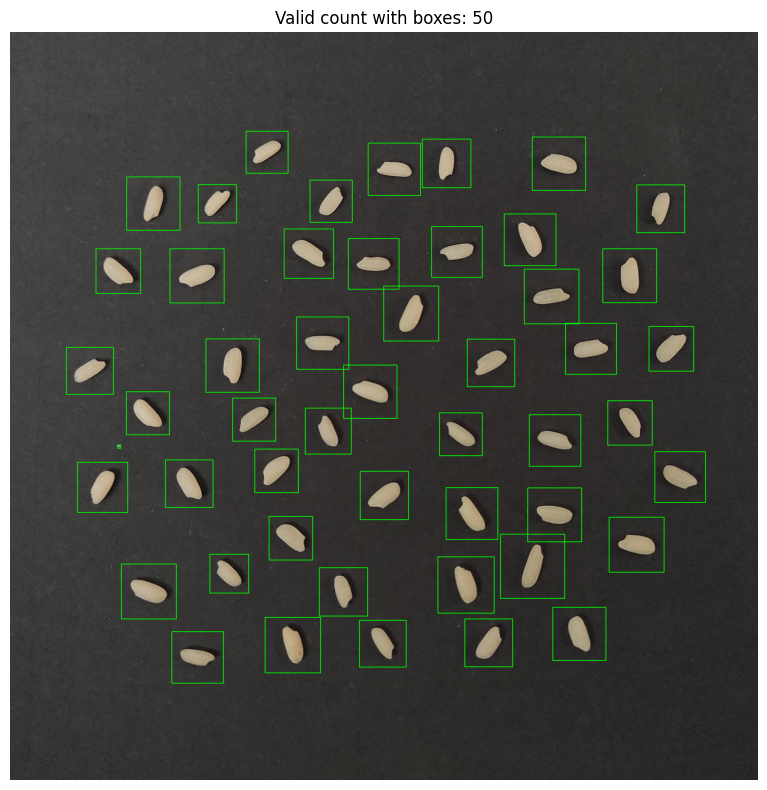

In [ ]:
ori_img = cv2.imread('beras mentik.jpg')
gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
draw_img = ori_img.copy()

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

padding = 1.5
count = 0

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if area < 50:
        continue

    s = int(max(w, h) * padding)
    cx, cy = x + w // 2, y + h // 2
    x0 = max(0, cx - s // 2)
    y0 = max(0, cy - s // 2)
    s = min(s, min(gray.shape[1] - x0, gray.shape[0] - y0))

    cv2.rectangle(draw_img, (x0, y0), (x0 + s, y0 + s), (0, 255, 0), 2)
    count += 1

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title(f'Valid count with boxes: {count}')
plt.axis('off')
plt.tight_layout()
plt.show()

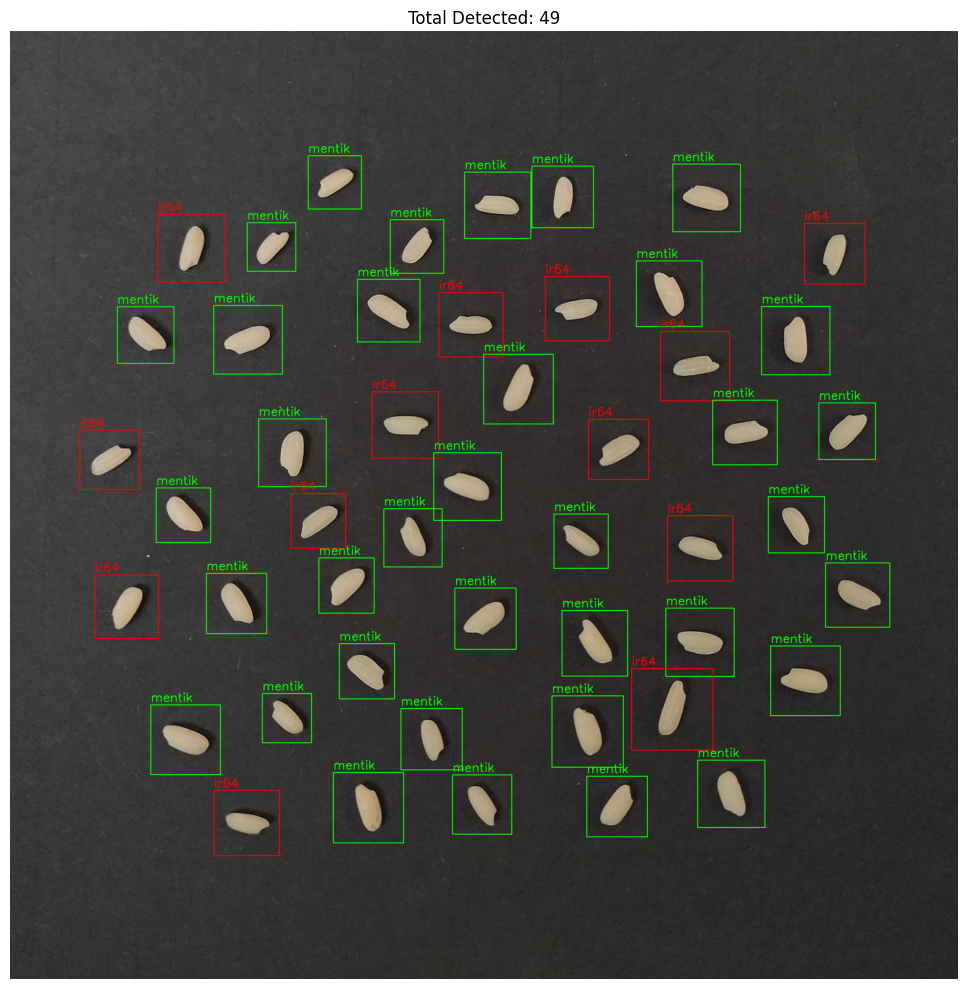

In [ ]:
class_names = ['ciherang', 'ir64', 'mentik']
label_colors = {
    'ciherang': (255, 0, 0),
    'ir64': (0, 0, 255),
    'mentik': (0, 255, 0),
}

img_path = 'beras mentik.jpg'
ori_img = cv2.imread(img_path)
draw_img = ori_img.copy()
gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)

with open(img_path, 'rb') as f:
    input_bytes = f.read()
output_bytes = remove(input_bytes)
img_no_bg = Image.open(BytesIO(output_bytes)).convert("RGB")
img_np = np.array(img_no_bg)

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

count = 0

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    if area < 300:
        continue

    side = int(max(w, h) * 1.5)
    cx_int, cy_int = int(cx), int(cy)
    x1 = max(0, cx_int - side // 2)
    y1 = max(0, cy_int - side // 2)

    side = min(side, min(img_np.shape[1] - x1, img_np.shape[0] - y1))
    crop = img_np[y1:y1 + side, x1:x1 + side]

    resized = cv2.resize(crop, (224, 224))
    x_input = tf.expand_dims(resized / 255.0, axis=0)

    pred = model.predict(x_input, verbose=0)
    score = tf.nn.softmax(pred[0])
    label = class_names[np.argmax(score)]
    color = label_colors.get(label, (0, 255, 255))

    cv2.rectangle(draw_img, (x1, y1), (x1 + side, y1 + side), color, 2)
    cv2.putText(draw_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1.2, color=color, thickness=2)
    count += 1

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title(f'Total Detected: {count}')
plt.axis('off')
plt.tight_layout()
plt.show()

#13.&nbsp;Streamlit Deployment

Streamlit Deployment can be accessed via the following link:
[DenseNet-201 Rice Variety Classification](https://densenet201-rice-variety-classification2.streamlit.app/)

Preview:
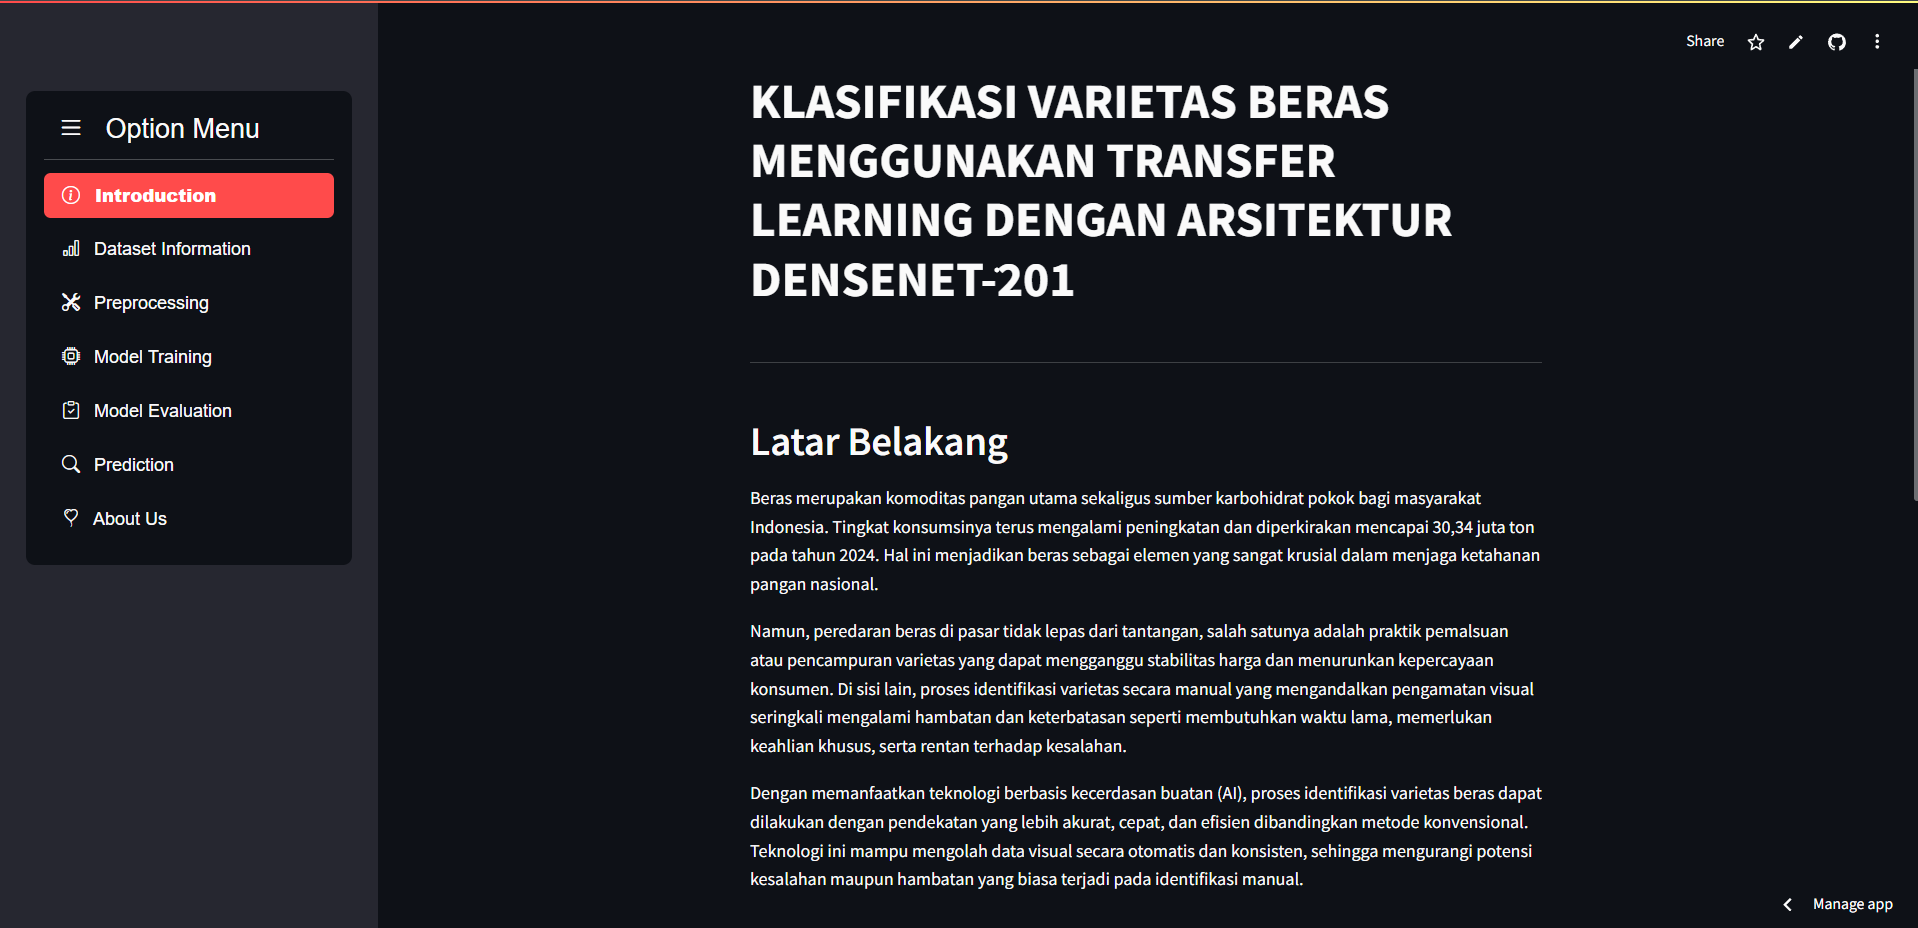